In [127]:
# https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import os
import cv2
import numpy as np

In [180]:
EPOCHS = 1
NUM_CLASSES = 10
BATCH_SIZE = 100
# Data size of 500-1000 should typically have a learning rate of 0.001
# My test data sample is only 100 so I've used learning rate of 0.0001
LEARNING_RATE = 0.001

DATA_PATH = './'
MODEL_PATH = './'

In [181]:
# data transformation into specific Pytorch Tensor data type used in Pytorch for all various data and weight operations
# Compose() normalizes the data into ranges of -1 to 1 or 0 to 1. Means of 0.1307 and Standard deviation of 0.3081
# NOTE: Since we're using MNIST dataset that is grayscale (single channel) we do NOT necessarily need to provide MEANS and STD
# NOTE: For color images, we need MEANS and STD to be applied to each of the 3 channels (each channel for RGB spectrum)
transform_data = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=transform_data, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=transform_data, download=True)

In [182]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [183]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential( # this allows us to create sequentially ordered layers in our network
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), # input of a single grayscale img, output (channels) of 32,
                                                                  # kernel is 5x5 window or filter as it goes through each channel's img features,
                                                                  # stride shifts the kernel or window one to the right
                                                                  # padding is calculated as 2 with the given input (see docu for eq)
            nn.ReLU(), # activation function via Rectified Linear Unit
            nn.MaxPool2d(kernel_size=2, stride=2)) # padding defaults to 0
            # the output from layer1 will be 32 channels of 14x14 'images' due to halfing the size from stride = 2

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), # input of 32 channels from layer1, outputting 64 channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
            # the output from layer2 will be 64 channels of 7x7 'images' due to halfing the size from stride = 2

        self.drop_out = nn.Dropout() # to avoid over-fitting within the model
        self.fc1 = nn.Linear(7*7*64, 1000) # input of 7x7 images size multiplied by 64 channels, output 1000
        self.fc2 = nn.Linear(1000, 10)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1) # we MUST flatten the data prior inserting into Linear network.
                                     # Flattening data dimensions from 7 x 7 x 64 channels into 3136 x 1
        x = self.drop_out(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        # NOTE: Softmax is NOT included for Mean Squared Error (MSE) but IS included for Cross Entropy
        #meep = nn.Softmax(dim=1)
        #return meep(x)
        return x

In [184]:
net = ConvNeuralNetwork()

# Loss and optimizer
#loss = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [185]:
def train_dataset(net, data):
    data_length = len(data)
    loss_list = []
    accuracy_list = []
    for epoch in range(EPOCHS):
        for i, (images, labels) in enumerate(data):
            # Execute forward pass
            outputs = net(images)
            calc_loss = loss(outputs, labels)
            loss_list.append(calc_loss.item()) # calc_loss is still a tensor so to extract the data we must use .item()
            
            # Back Propragation and Adam Optimizations
            optimizer.zero_grad() # zeroing the gradient prior back propragation
            calc_loss.backward() # back propragation
            optimizer.step()
            
            # Tracking Accuracy
            total = labels.size(0) # EACH EPOCH'S BATCH SIZE WHICH SHOULD BE 100
            
            _, predicted = torch.max(outputs, 1) # torch.max(tensor, axis) returns '_' as max values within each img and 'predicted' as
                                                 # max values' index number which correlates to the predicted img number.
                                                 # Each in index will represent the number 0-9, totaling 10.
                                                 # Remember that the output for each image results will output tensor length of 10 data points.
            
            correct = (predicted == labels).sum().item() # Checking prediction tensor with label tensor to see if predictions are correct.
                                                         # Sum all the correct predictions with .sum() and convert from tensor to int with .item()
            
            accuracy_list.append(correct / total)
            
            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {calc_loss.item()}, Accuracy: {(correct/total) * 100} %')

In [186]:
train_dataset(net, train_loader)

Epoch [1/1], Loss: 0.277619868516922, Accuracy: 95.0 %
Epoch [1/1], Loss: 0.0568741038441658, Accuracy: 99.0 %
Epoch [1/1], Loss: 0.14643609523773193, Accuracy: 97.0 %
Epoch [1/1], Loss: 0.03588870167732239, Accuracy: 99.0 %
Epoch [1/1], Loss: 0.06293945014476776, Accuracy: 98.0 %
Epoch [1/1], Loss: 0.07110723853111267, Accuracy: 98.0 %


In [187]:
def test_dataset(net, data):
    correct = 0
    total = 0
    # eval() disables any drop-out o batch normalization layers within our network
    net.eval()
    
    # We do NOT want to train/optimize our data and only test our 
    # neural network's accuracy, so gradient must not be used!
    with torch.no_grad():
        for images, labels in data:
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(total)
        print(f'Test Accuracy from 10,000 test images: {(correct / total) * 100}%')

In [188]:
test_dataset(net, test_loader)

10000
Test Accuracy from 10,000 test images: 98.35000000000001%


In [164]:
class DataGenerator():
    IMG_SIZE = 28
    DATA_DIR = os.getcwd() + '/Numbers_Test/'
    LABELS = [0,1,2,3,4,5,6,7,8,9]
    dataset = []
    
    def create_data(self):
        for label in self.LABELS:
            data_path = os.path.join(self.DATA_DIR, str(label))
            for f in os.listdir(data_path):
                try:
                    path = os.path.join(data_path, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE)) # image is already 28x28 but for usage on any others in future
                    self.dataset.append([np.array(img), np.eye(10)[self.LABELS[label]]]) # setting the numpy 'eye' outcomes for each img
                except Exception as e:
                    pass
        
        np.random.shuffle(self.dataset)
        np.save(self.DATA_DIR + "NumberImgData.npy", self.dataset)

In [165]:
test = DataGenerator()
test.create_data()

In [166]:
outer_sample = np.load("./Numbers_Test/NumberImgData.npy", allow_pickle=True)
print(len(outer_sample))

100


4


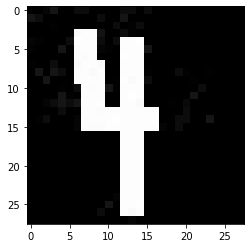

In [189]:
import matplotlib.pyplot as plt

data_index = 90

print(np.argmax(outer_sample[data_index][1]))
plt.imshow(outer_sample[data_index][0], cmap="gray") # first index contains the data selection from 0 to n
                                            # second index contains the img pixel data [0] and results [1]
plt.show()

In [168]:
X = torch.Tensor([i[0] for i in outer_sample]).view(-1, 28, 28) # separating the img values into the proper format
Y = torch.Tensor([(i[1]) for i in outer_sample]) # separating the img answers

test_percent = 0.1
test_val = int(len(X) * test_percent)

train_X = X[:-test_val]
train_Y = Y[:-test_val]

test_X = X[-test_val:]
test_Y = Y[-test_val:]
print(len(train_X))
print(len(test_X))

90
10


In [190]:
def test_outer_dataset(net, imgData, imgResults):
    correct = 0
    total = 0
    # eval() disables any drop-out or batch normalization layers within our network
    net.eval()
    
    # We do NOT want to train/optimize our data and only test our 
    # neural network's accuracy, so gradient must not be used!
    with torch.no_grad():
        for i in range(len(imgData)):
            batch_X = imgData[i].view(-1, 1, 28, 28)
            # For Cross Entropy Loss, you must have all the batch's number results in a tensor
            batch_Y = torch.argmax(imgResults[i])
            # Whereas for Mean Standard Error (MSE) Loss, you must have the batch's number results in a tensor AS a ONE HOT VECTOR
            # batch_Y = imgResults[i:i + BATCH_SIZE] # This format is already in a one HOT VECTOR format
            number_answer = torch.argmax(imgResults[i])
            outputs = net(batch_X)
            predicted_num = torch.argmax(outputs).item()
            print(f'predicted: {predicted_num}')
            print(f'answer: {number_answer}')
            print('------')
            #print(outputs)
            if predicted_num == number_answer:
                correct += 1
            total += 1
            
        print(f'Total: {total}')
        print(f'Test Accuracy from outside images samples: {(correct / total) * 100}%')

In [192]:
test_outer_dataset(net, train_X, train_Y)

predicted: 5
answer: 5
------
predicted: 3
answer: 8
------
predicted: 0
answer: 0
------
predicted: 5
answer: 5
------
predicted: 6
answer: 6
------
predicted: 1
answer: 1
------
predicted: 8
answer: 8
------
predicted: 9
answer: 9
------
predicted: 8
answer: 8
------
predicted: 3
answer: 3
------
predicted: 8
answer: 0
------
predicted: 4
answer: 4
------
predicted: 2
answer: 2
------
predicted: 9
answer: 9
------
predicted: 4
answer: 4
------
predicted: 9
answer: 9
------
predicted: 3
answer: 3
------
predicted: 4
answer: 1
------
predicted: 7
answer: 9
------
predicted: 6
answer: 6
------
predicted: 3
answer: 3
------
predicted: 5
answer: 5
------
predicted: 5
answer: 5
------
predicted: 4
answer: 4
------
predicted: 3
answer: 7
------
predicted: 7
answer: 2
------
predicted: 2
answer: 2
------
predicted: 9
answer: 9
------
predicted: 2
answer: 2
------
predicted: 3
answer: 7
------
predicted: 0
answer: 0
------
predicted: 7
answer: 7
------
predicted: 6
answer: 6
------
predicted:

In [171]:
def train_outer_dataset(net, imgData, imgResults):
    EPOCHS = 20
    BATCH_SIZE = 5
    for epoch in range(EPOCHS):
        for i in range(0, len(imgData), BATCH_SIZE): # splitting up all the data into their respective batch size using 'range'
            batch_X = imgData[i:i + BATCH_SIZE].view(-1, 1, 28, 28)
            # For Cross Entropy Loss, you must have all the batch's number results in a tensor
            batch_Y = torch.argmax(imgResults[i:i + BATCH_SIZE], 1)
            # Whereas for Mean Standard Error (MSE) Loss, you must have the batch's number results in a tensor AS a ONE HOT VECTOR
            # batch_Y = imgResults[i:i + BATCH_SIZE] # This format is already in a one HOT VECTOR format
            net.zero_grad()
            outputs = net(batch_X)
            calc_loss = loss(outputs, batch_Y)
            calc_loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch}. Loss: {calc_loss}')

In [172]:
train_outer_dataset(net, train_X, train_Y)

Epoch: 0. Loss: 1.4305112472356996e-07
Epoch: 1. Loss: 1.4305112472356996e-07
Epoch: 2. Loss: 1.4305112472356996e-07
Epoch: 3. Loss: 1.4305112472356996e-07
Epoch: 4. Loss: 1.4305112472356996e-07
Epoch: 5. Loss: 1.4305112472356996e-07
Epoch: 6. Loss: 1.4305112472356996e-07
Epoch: 7. Loss: 1.4305112472356996e-07
Epoch: 8. Loss: 1.1920926823449918e-07
Epoch: 9. Loss: 1.1920926823449918e-07
Epoch: 10. Loss: 1.1920926823449918e-07
Epoch: 11. Loss: 1.1920926823449918e-07
Epoch: 12. Loss: 1.4305111051271524e-07
Epoch: 13. Loss: 1.4305111051271524e-07
Epoch: 14. Loss: 1.4305111051271524e-07
Epoch: 15. Loss: 1.4305111051271524e-07
Epoch: 16. Loss: 1.4305111051271524e-07
Epoch: 17. Loss: 1.4305111051271524e-07
Epoch: 18. Loss: 1.4305111051271524e-07
Epoch: 19. Loss: 1.6689295989635866e-07
